# Yelp API - Lab


## Introduction 

Now that we've seen how the Yelp API works and some basic Folium visualizations, it's time to put those skills to work in order to create a working map! Taking things a step further, you'll also independently explore how to perform pagination in order to retrieve a full results set from the Yelp API!

## Objectives

You will be able to: 
* Create HTTP requests to get data from Yelp API
* Parse HTTP responses and perform data analysis on the data returned
* Perform pagination to retrieve troves of data!
* Create a simple geographical system to view information about selected businesses, at a given location. 

## Problem Introduction

You've now worked with some API calls, but we have yet to see how to retrieve a more complete dataset in a programmatic manner. Returning to the Yelp API, the [documentation](https://www.yelp.com/developers/documentation/v3/business_search) also provides us details regarding the API limits. These often include details about the number of requests a user is allowed to make within a specified time limit and the maximum number of results to be returned. In this case, we are told that any request has a maximum of 50 results per request and defaults to 20. Furthermore, any search will be limited to a total of 1000 results. To retrieve all 1000 of these results, we would have to page through the results piece by piece, retrieving 50 at a time. Processes such as these are often referred to as pagination.

In this lab, you will define a search and then paginate over the results to retrieve all of the results. You'll then parse these responses as a DataFrame (for further exploration) and create a map using Folium to visualize the results geographically.

## Part I - Make the Initial Request

Start by making an initial request to the Yelp API. Your search must include at least 2 parameters: **term** and **location**. For example, you might search for pizza restaurants in NYC. The term and location is up to you but make the request below.

In [2]:
# Your code here
import requests
import pandas as pd
import json

# function to pull client information
def get_keys(path):
    with open(path) as f:
        return json.load(f)
    
keys = get_keys("/Users/IBM/.secret/yelp_api.json")
client_id = keys['client_id']
api_key = keys['api_key']

# API parameters
url = 'https://api.yelp.com/v3/businesses/search'

headers = {
        'Authorization': 'Bearer {}'.format(api_key),
    }

term = 'pizza'
location = 'Chicago IL'
url_params = {
                'term': term.replace(' ', '+'),
                'location': location.replace(' ', '+'),
            }

# API Request
response = requests.get(url, headers=headers, params=url_params) 

print('Response Status Code:', response)
print('Response Type:', type(response.text))
print('Response JSON Keys:', response.json().keys())
print('Number of Businesses in Response:', response.json()['total'])
print('Response Region:', response.json()['region'])
print('Total Number of Businesses from Request:', len(response.json()['businesses']))
print('Response Content:\n', response.text[:1000])

Response Status Code: <Response [200]>
Response Type: <class 'str'>
Response Content:
 {"businesses": [{"id": "DXwSYgiXqIVNdO9dazel6w", "alias": "pequods-pizzeria-chicago", "name": "Pequod's Pizzeria", "image_url": "https://s3-media2.fl.yelpcdn.com/bphoto/jlB3XA4XnnoU6omD9TSk5Q/o.jpg", "is_closed": false, "url": "https://www.yelp.com/biz/pequods-pizzeria-chicago?adjust_creative=ylsONDPp8isfoykj7TbYyA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=ylsONDPp8isfoykj7TbYyA", "review_count": 5738, "categories": [{"alias": "pizza", "title": "Pizza"}], "rating": 4.0, "coordinates": {"latitude": 41.92187, "longitude": -87.664486}, "transactions": ["restaurant_reservation", "pickup", "delivery"], "price": "$$", "location": {"address1": "2207 N Clybourn Ave", "address2": "", "address3": "", "city": "Chicago", "zip_code": "60614", "country": "US", "state": "IL", "display_address": ["2207 N Clybourn Ave", "Chicago, IL 60614"]}, "phone": "+17733271512", "display_phone": "(773

## Pagination

Now that you have an initial response, you can examine the contents of the JSON container. For example, you might start with ```response.json().keys()```. Here, you'll see a key for `'total'`, which tells you the full number of matching results given your query parameters. Write a loop (or ideally a function) which then makes successive API calls using the offset parameter to retrieve all of the results (or 5000 for a particularly large result set) for the original query. As you do this, be mindful of how you store the data. Your final goal will be to reformat the data concerning the businesses themselves into a pandas DataFrame from the json objects.

**Note: be mindful of the API rate limits. You can only make 5000 requests per day and are also can make requests too fast. Start prototyping small before running a loop that could be faulty. You can also use time.sleep(n) to add delays. For more details see https://www.yelp.com/developers/documentation/v3/rate_limiting.**

In [40]:
# Your code here; use a function or loop to retrieve all the results from your original request
import time

# function to pull page from API
def yelp_request(url_params, api_key):
    url = 'https://api.yelp.com/v3/businesses/search'
    headers = {'Authorization': 'Bearer {}'.format(api_key)}
    response = requests.get(url, headers=headers, params=url_params)    
    df = pd.DataFrame(response.json()['businesses'])
    
    return df

# while loop to build pagination results
def business_pagination(url_params, api_key):
    yelp_total = response.json()['total']
    print('Yelp Matches for Request: {}'.format(yelp_total))
    result_limit = 1000
    print('Maximum Results for Pagination (due to rate-limiting): {}'.format(result_limit))
    current_count = 0
    df_pgn = []
    while current_count < yelp_total and current_count < result_limit: # conditional on request and rate-limiting calls
        url_params['offset'] = current_count
        df_pgn.append(yelp_request(url_params, api_key))
        time.sleep(1) # for rate-limiting speed
        current_count += 50
    df = pd.concat(df_pgn, ignore_index=True)
    return df

# Pagination Project
term = 'pizza'
location = 'Chicago IL'
url_params = {  'term': term.replace(' ', '+'),
                'location': location.replace(' ', '+'),
                'limit': 50
             }
df = business_pagination(url_params, api_key)
print('Number of Pagination Function Results:', len(df))
print('Preview of Results:')
df.head()

Yelp Matches for Request: 4400
Maximum Results for Pagination (due to rate-limiting): 1000
Number of Pagination Function Results: 1000
Preview of Results:


,alias,categories,coordinates,display_phone,distance,id,image_url,is_closed,location,name,phone,price,rating,review_count,transactions,url
0,pequods-pizzeria-chicago,"[{'alias': 'pizza', 'title': 'Pizza'}]","{'latitude': 41.92187, 'longitude': -87.664486}",(773) 327-1512,2158.708458,DXwSYgiXqIVNdO9dazel6w,https://s3-media2.fl.yelpcdn.com/bphoto/jlB3XA...,False,"{'address1': '2207 N Clybourn Ave', 'address2'...",Pequod's Pizzeria,+17733271512,$$,4.0,5738,"[delivery, restaurant_reservation, pickup]",https://www.yelp.com/biz/pequods-pizzeria-chic...
1,lou-malnatis-pizzeria-chicago,"[{'alias': 'pizza', 'title': 'Pizza'}, {'alias...","{'latitude': 41.890357, 'longitude': -87.633704}",(312) 828-9800,4000.999053,8vFJH_paXsMocmEO_KAa3w,https://s3-media1.fl.yelpcdn.com/bphoto/cv0OrG...,False,"{'address1': '439 N Wells St', 'address2': '',...",Lou Malnati's Pizzeria,+13128289800,$$,4.0,5865,"[delivery, pickup]",https://www.yelp.com/biz/lou-malnatis-pizzeria...
2,piece-brewery-and-pizzeria-chicago,"[{'alias': 'pizza', 'title': 'Pizza'}, {'alias...","{'latitude': 41.9103256994423, 'longitude': -8...",(773) 772-4422,591.061943,Z2nOMPedr7XYhgYhILJjEA,https://s3-media1.fl.yelpcdn.com/bphoto/aIALgJ...,False,"{'address1': '1927 W North Ave', 'address2': '...",Piece Brewery and Pizzeria,+17737724422,$$,4.0,3468,"[delivery, pickup]",https://www.yelp.com/biz/piece-brewery-and-piz...
3,craft-pizza-chicago,"[{'alias': 'pizza', 'title': 'Pizza'}, {'alias...","{'latitude': 41.9048454, 'longitude': -87.6775...",(773) 442-7238,40.899218,8-eWe05s8Z7I1AejHXNsEA,https://s3-media2.fl.yelpcdn.com/bphoto/Qr4NvY...,False,"{'address1': '1252 N Damen Ave', 'address2': '...",Craft Pizza,+17734427238,$$,4.5,235,"[delivery, pickup]",https://www.yelp.com/biz/craft-pizza-chicago?a...
4,roberts-pizza-and-dough-company-chicago-2,"[{'alias': 'pizza', 'title': 'Pizza'}]","{'latitude': 41.8906916389975, 'longitude': -8...",(312) 265-1328,5263.786398,Rn3o8GcYBPFJX5MWJn0r1Q,https://s3-media3.fl.yelpcdn.com/bphoto/z5Y31-...,False,"{'address1': '465 N McClurg', 'address2': '', ...",Robert's Pizza & Dough Company,+13122651328,$$,4.5,286,[],https://www.yelp.com/biz/roberts-pizza-and-dou...


## Exploratory Analysis

Take the restaurants from the previous question and do an initial exploratory analysis. At minimum, this should include looking at the distribution of features such as price, rating and number of reviews as well as the relations between these dimensions.

Price unique values: ['$$' '$' nan '$$$' '$$$$']

Rating unique values: [4.  4.5 5.  3.5 3.  2.5 2.  1.5 1. ]

Review_Count unique values:
 [5738 5865 3468  235  286 1053   85 2532   97 2489  383  256  192  240
  388   79  104  194 1148  333  346  393   99 1463 2265 2605  590  345
   34  579 1020  336  334  228   21  540 2418   98   81  554 1457  272
  171  915  255  854 1145    7  757   46  339 1391  862  382  147   40
  207  186 1052  625  535  483  360  407  347   66  839  107  352   86
  191  288  371  391  200  799  279  544  118  790   68  154  139  174
  325  176  144   45  474   82 3600  583  301 4530  504   27  294  868
  131  437   22  559 1366  479   58  151  181  155    3  552  493  290
   89  473  117   50  401   69 1717  613   88   95  622  372    8  507
  280  344   76  120   54  168  265  977   57  124   24   72  221   78
  323  253  148  300   32  160  175  335   64   80  112  428   19   28
   39 1000   23   93   15  292  185  135    6  110  380  165  727   38
  122  1

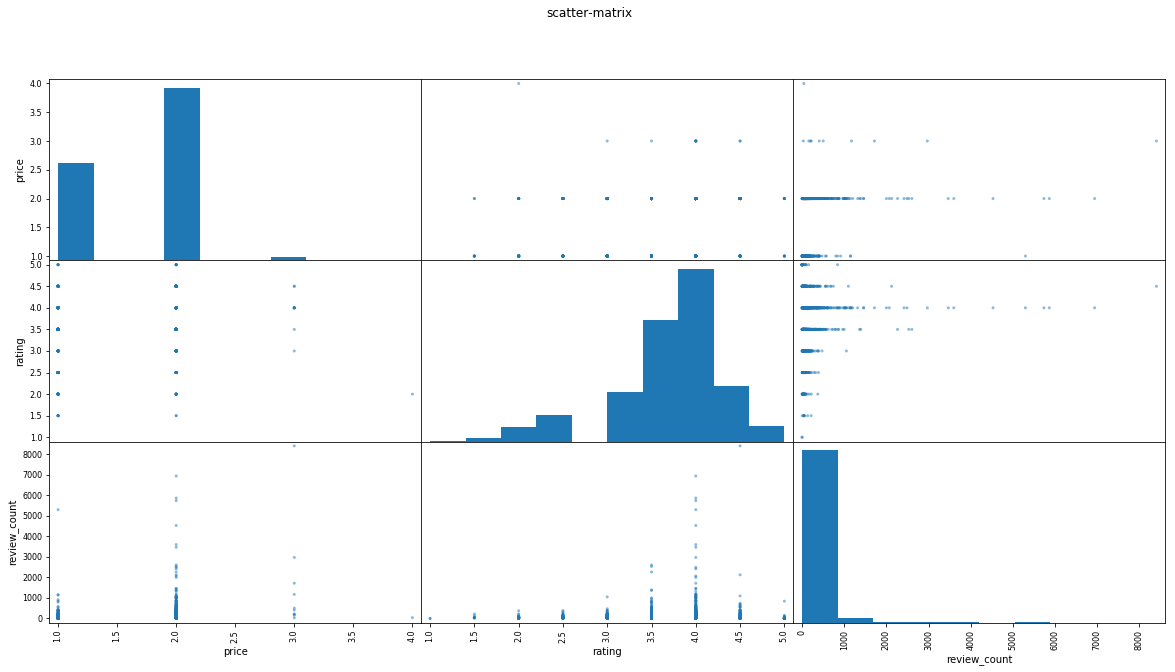

In [44]:
# Your code here
import matplotlib.pyplot as plt
%matplotlib inline

df_eda = df.copy()
print('Price unique values:', df_eda.price.unique())
print('\nRating unique values:', df_eda.rating.unique())
print('\nReview_Count unique values:\n', df_eda.review_count.unique())

# handle data type and missing values
df_eda.price = df_eda.price.fillna(value=0)
price_map = {"$": 1, "$$": 2, "$$$": 3, "$$$$": 4}
df_eda.price = df_eda.price.map(price_map)

pd.plotting.scatter_matrix(df_eda[['price', 'rating', 'review_count']], figsize=(20, 10))
plt.suptitle('scatter-matrix')
plt.show();

## Mapping

Look at the initial Yelp example and try and make a map using Folium of the restaurants you retrieved. Be sure to also add popups to the markers giving some basic information such as name, rating and price.

In [54]:
# Your code here
#!pip install folium
import folium

coordinates = df['coordinates'].iloc[0]
lat = coordinates['latitude']
long = coordinates['longitude']
# base map
yelp_api_map = folium.Map([lat, long])

# add popups to markers
for i in df.index:
    try:
        coordinates = df['coordinates'][i]
        lat = coordinates['latitude']
        long = coordinates['longitude']
        name = df['name'][i]
        price = df['price'][i]
        rating = df['rating'][i]
        review_count = df['review_count'][i]
        popup_text = "{}\n\n\nPrice: {} Rating: {} Review Count: {}".format(name, str(price), str(rating), str(review_count))
        popup = folium.Popup(popup_text, parse_html=True)
        marker = folium.Marker(location=[lat, long], popup=popup)
        marker.add_to(yelp_api_map)
    except:
        print('Error Encountered on Row: {}'.format(i))
        
# display map       
yelp_api_map

## Summary

Nice work! In this lab, you synthesized your skills for the day, making multiple API calls to Yelp in order to paginate through a results set, performing some basic exploratory analysis and then creating a nice map visual to display the results! Well done!